In [14]:

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip.clip as clip
from transformers import CLIPProcessor, CLIPModel
import os
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

2024-03-27 18:16:06.610299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [5]:

# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)


In [6]:
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

In [7]:
data_path = "data/PandasBears/Train"

In [8]:
list_image_path = []
list_txt = []
for clas in os.listdir(data_path):
    for img in os.listdir(os.path.join(data_path,clas)):
        img_path = os.path.join(data_path,clas,img)
        list_image_path.append(img_path)
        list_txt.append(clas)
        


In [9]:
dataset = image_title_dataset(list_image_path, list_txt)

In [10]:
train_dataloader = DataLoader(dataset, batch_size=300, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([300, 3, 224, 224])
Labels batch shape: torch.Size([300, 77])


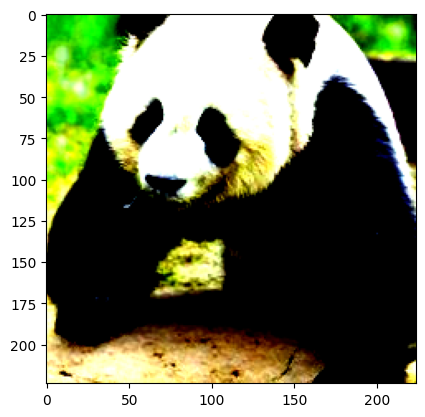

Label: tensor([49406, 12952, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=torch.int32)


In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0).numpy()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset


In [15]:
# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch 
        
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

: 

In [77]:
data = tf.keras.utils.image_dataset_from_directory('data/PandasBears/Train')

class_names = data.class_names



# print("Class names:", class_names)
# for images, labels in data:
#     print(labels.numpy())
#     plt.imshow(images[0].numpy().astype("uint8"))
#     break  # Break after printing the first batch to avoid printing all batches




    


Found 500 files belonging to 2 classes.


In [94]:
# Create an iterator
iterator = iter(data)

# Get the next batch
images, labels = next(iterator)

# Process the batch
print(images[1].shape)
print(class_names[labels[1]])




(256, 256, 3)
Bear


In [52]:
train_dataloader = DataLoader(data, batch_size=100, shuffle=True) 

In [54]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

TypeError: '_PrefetchDataset' object is not subscriptable

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

num_epochs = 30
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch 
        
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

In [ ]:

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, text_list, image_list, labels, transform=None):
        self.text_list = text_list
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.text_list[idx]
        image = self.image_list[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return text, image, label

# Load pre-trained CLIP model and tokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define hyperparameters
batch_size = 8
learning_rate = 1e-4
num_epochs = 5

# Prepare data
# Assume you have text_list (text descriptions), image_list (image paths), and labels (0 or 1)
# Here, we create a DataLoader using a custom dataset class
custom_dataset = CustomDataset(text_list, image_list, labels, transform=transforms.ToTensor())
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Define optimizer and loss function
optimizer = AdamW(clip_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Fine-tuning loop
for epoch in range(num_epochs):
    clip_model.train()
    total_loss = 0.0
    
    for texts, images, labels in data_loader:
        optimizer.zero_grad()

        # Tokenize texts
        inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)

        # Forward pass
        outputs = clip_model(**inputs, pixel_values=images)
        logits_per_image = outputs.logits_per_image
        loss = criterion(logits_per_image, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss}")

# Evaluation (not shown here)
# Evaluate the fine-tuned model on a separate validation set or through cross-validation
# Compute metrics such as accuracy, precision, recall, etc.


In [4]:

import tensorflow as tf

2024-03-22 18:48:09.573522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import os

In [6]:
data_dir = 'data/PandasBears'

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data/PandasBears/Train')

Found 500 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>